# Ethereum Machine Learning Trading Model

## Importing libraries

In [71]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set()
from time import time

import joblib

# display all columns
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

from bayes_opt import BayesianOptimization

# Libraries for Deep Learning Models
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.linear_model import LogisticRegression

# needed for `HistGradientBoostingClassifier`
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    StratifiedKFold,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

# from `keras.optimizers` import SGD
import warnings

warnings.resetwarnings()
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore")

## Importing the data

In [73]:
# To fetch financial data
import yfinance as yf

# Set the ticker as 'ETH-USD'
ETH_Ticker = yf.Ticker("ETH-USD")#
ETH_Data = ETH_Ticker.history(period="10y")
# ETH_Ticker = yf.Ticker("ETH-USD")
# ETH_Data = ETH_Ticker.history(period="max")
ETH_Data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-11-09 00:00:00+00:00,308.644989,329.451996,307.056000,320.884003,893249984,0.0,0.0
2017-11-10 00:00:00+00:00,320.670990,324.717987,294.541992,299.252991,885985984,0.0,0.0
2017-11-11 00:00:00+00:00,298.585999,319.453003,298.191986,314.681000,842300992,0.0,0.0
2017-11-12 00:00:00+00:00,314.690002,319.153015,298.513000,307.907990,1613479936,0.0,0.0
2017-11-13 00:00:00+00:00,307.024994,328.415009,307.024994,316.716003,1041889984,0.0,0.0


## Explorative Analysis on the data

In [75]:
ETH_Data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2828 entries, 2017-11-09 00:00:00+00:00 to 2025-08-08 00:00:00+00:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          2828 non-null   float64
 1   High          2828 non-null   float64
 2   Low           2828 non-null   float64
 3   Close         2828 non-null   float64
 4   Volume        2828 non-null   int64  
 5   Dividends     2828 non-null   float64
 6   Stock Splits  2828 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 176.8 KB


In [76]:
ETH_Data.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,2828.000000,2828.000000,2828.000000,2828.000000,2.828000e+03,2828.0,2828.0
mean,1574.197841,1617.451086,1527.040970,1575.222292,1.382654e+10,0.0,0.0
std,1225.848221,1258.450365,1189.732713,1225.999689,1.104219e+10,0.0,0.0
min,84.279694,85.342743,82.829887,84.308296,6.217330e+08,0.0,0.0
25%,308.799713,318.480034,294.747444,309.255486,5.976745e+09,0.0,0.0
50%,1586.974548,1634.782776,1552.729248,1587.918579,1.149781e+10,0.0,0.0
75%,2528.627991,2606.434326,2456.779175,2528.866394,1.851152e+10,0.0,0.0
max,4810.071289,4891.704590,4718.039062,4812.087402,9.245355e+10,0.0,0.0


In [77]:
print("Null Values =", ETH_Data.isnull().values.any())

Null Values = False


In [78]:
# Create short simple moving average over the short window
ETH_Data["short_moving_avg"] = (
    ETH_Data["Close"].rolling(window=10, min_periods=1, center=False).mean()
)

# Create long simple moving average over the long window
ETH_Data["long_maving_avg"] = (
    ETH_Data["Close"].rolling(window=60, min_periods=1, center=False).mean()
)

# Create signals
ETH_Data["signal"] = np.where(
    ETH_Data["short_moving_avg"] > ETH_Data["long_maving_avg"], 1.0, 0.0
)
ETH_Data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,short_moving_avg,long_maving_avg,signal
Date,,,,,,,,,,
2017-11-09 00:00:00+00:00,308.644989,329.451996,307.056000,320.884003,893249984,0.0,0.0,320.884003,320.884003,0.0
2017-11-10 00:00:00+00:00,320.670990,324.717987,294.541992,299.252991,885985984,0.0,0.0,310.068497,310.068497,0.0
2017-11-11 00:00:00+00:00,298.585999,319.453003,298.191986,314.681000,842300992,0.0,0.0,311.605998,311.605998,0.0
2017-11-12 00:00:00+00:00,314.690002,319.153015,298.513000,307.907990,1613479936,0.0,0.0,310.681496,310.681496,0.0
2017-11-13 00:00:00+00:00,307.024994,328.415009,307.024994,316.716003,1041889984,0.0,0.0,311.888397,311.888397,0.0


## Adding Features to the model

In [80]:
# calculation of exponential moving average

def EMA(df, n):
    EMA = pd.Series(df["Close"].ewm(span=n, min_periods=n).mean(), name="EMA_" + str(n))
    return EMA

ETH_Data["EMA10"] = EMA(ETH_Data, 10)
ETH_Data["EMA30"] = EMA(ETH_Data, 30)
ETH_Data["EMA200"] = EMA(ETH_Data, 200)
ETH_Data.head()

# calculation of rate of change
def RC(df, n):
    M = df.diff(n - 1)
    N = df.shift(n - 1)
    RC = pd.Series(((M / N) * 100), name="RC_" + str(n))
    return RC


ETH_Data["RC10"] = RC(ETH_Data["Close"], 10)
ETH_Data["RC30"] = RC(ETH_Data["Close"], 30)


# Calculation of price momentum
def MOM(df, n):
    MOM = pd.Series(df.diff(n), name="Momentum_" + str(n))
    return MOM


ETH_Data["MOM10"] = MOM(ETH_Data["Close"], 10)
ETH_Data["MOM30"] = MOM(ETH_Data["Close"], 30)


# calculation of relative strength index
def RSI(series, period):
    delta = series.diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[period - 1]] = np.mean(u[:period])  # first value is sum of avg gains
    u = u.drop(u.index[: (period - 1)])
    d[d.index[period - 1]] = np.mean(d[:period])  # first value is sum of avg losses
    d = d.drop(d.index[: (period - 1)])
    rs = (
        u.ewm(com=period - 1, adjust=False).mean()
        / d.ewm(com=period - 1, adjust=False).mean()
    )
    return 100 - 100 / (1 + rs)


ETH_Data["RSI10"] = RSI(ETH_Data["Close"], 10)
ETH_Data["RSI30"] = RSI(ETH_Data["Close"], 30)
ETH_Data["RSI200"] = RSI(ETH_Data["Close"], 200)

# calculation of stochastic oscillator.


def STOK(close, low, high, n):
    STOK = (
        (close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())
    ) * 100
    return STOK


def STOD(close, low, high, n):
    STOK = (
        (close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())
    ) * 100
    STOD = STOK.rolling(3).mean()
    return STOD


ETH_Data["%K10"] = STOK(ETH_Data["Close"], ETH_Data["Low"], ETH_Data["High"], 10)
ETH_Data["%D10"] = STOD(ETH_Data["Close"], ETH_Data["Low"], ETH_Data["High"], 10)
ETH_Data["%K30"] = STOK(ETH_Data["Close"], ETH_Data["Low"], ETH_Data["High"], 30)
ETH_Data["%D30"] = STOD(ETH_Data["Close"], ETH_Data["Low"], ETH_Data["High"], 30)
ETH_Data["%K200"] = STOK(ETH_Data["Close"], ETH_Data["Low"], ETH_Data["High"], 200)
ETH_Data["%D200"] = STOD(ETH_Data["Close"], ETH_Data["Low"], ETH_Data["High"], 200)

In [81]:
ETH_Data.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,short_moving_avg,long_maving_avg,signal,EMA10,EMA30,EMA200,RC10,RC30,MOM10,MOM30,RSI10,RSI30,RSI200,%K10,%D10,%K30,%D30,%K200,%D200
Date,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-08-02 00:00:00+00:00,3487.956787,3535.558838,3370.943115,3392.741211,30165065282,0.0,0.0,3701.881226,2911.606055,1.0,3622.106727,3369.260961,2698.452749,-8.502263,35.248812,-236.962402,801.733887,40.918834,57.922534,52.596248,3.826181,19.176842,62.597315,72.035842,78.545714,83.761249
2025-08-03 00:00:00+00:00,3392.744385,3520.831299,3357.938965,3497.379150,19363593865,0.0,0.0,3680.818579,2926.418323,1.0,3599.428986,3377.526651,2706.402266,-6.167728,38.934847,-210.626465,988.860840,48.201854,59.931653,52.956245,23.929474,12.923545,69.464192,67.062189,82.642972,81.159577
2025-08-04 00:00:00+00:00,3497.613037,3734.977539,3491.554932,3718.986084,30905749658,0.0,0.0,3679.990503,2948.129997,1.0,3621.166640,3399.556292,2716.477727,-0.598972,44.638036,-8.280762,1201.706055,59.848811,63.726253,53.704580,61.959667,29.905107,84.555918,72.205808,91.320329,84.169672
2025-08-05 00:00:00+00:00,3719.817871,3720.656494,3547.621094,3611.899414,32778742296,0.0,0.0,3667.040845,2967.041740,1.0,3619.481690,3413.255848,2725.387395,-6.795624,42.032272,-129.496582,1040.662842,53.401730,60.845739,53.292869,43.582414,43.157185,76.893128,76.971079,87.127187,87.030163
2025-08-08 00:00:00+00:00,3912.589844,3950.392090,3885.151123,3950.392090,41352171520,0.0,0.0,3674.555396,2990.773185,1.0,3679.647217,3447.909799,2737.576497,4.302825,51.037402,75.145508,1407.378906,66.192400,65.887703,54.403333,100.000000,68.514027,100.000000,87.149682,100.000000,92.815839


In [82]:
def MA(df, n):
    MA = pd.Series(df["Close"].rolling(n, min_periods=n).mean(), name="MA_" + str(n))
    return MA

ETH_Data["MA21"] = MA(ETH_Data, 10)
ETH_Data["MA63"] = MA(ETH_Data, 30)
ETH_Data["MA252"] = MA(ETH_Data, 200)
ETH_Data.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,short_moving_avg,long_maving_avg,signal,EMA10,EMA30,EMA200,RC10,RC30,MOM10,MOM30,RSI10,RSI30,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-08-02 00:00:00+00:00,3487.956787,3535.558838,3370.943115,3392.741211,30165065282,0.0,0.0,3701.881226,2911.606055,1.0,3622.106727,3369.260961,2698.452749,-8.502263,35.248812,-236.962402,801.733887,40.918834,57.922534,52.596248,3.826181,19.176842,62.597315,72.035842,78.545714,83.761249,3701.881226,3314.055314,2498.480967
2025-08-03 00:00:00+00:00,3392.744385,3520.831299,3357.938965,3497.379150,19363593865,0.0,0.0,3680.818579,2926.418323,1.0,3599.428986,3377.526651,2706.402266,-6.167728,38.934847,-210.626465,988.860840,48.201854,59.931653,52.956245,23.929474,12.923545,69.464192,67.062189,82.642972,81.159577,3680.818579,3347.017342,2498.715175
2025-08-04 00:00:00+00:00,3497.613037,3734.977539,3491.554932,3718.986084,30905749658,0.0,0.0,3679.990503,2948.129997,1.0,3621.166640,3399.556292,2716.477727,-0.598972,44.638036,-8.280762,1201.706055,59.848811,63.726253,53.704580,61.959667,29.905107,84.555918,72.205808,91.320329,84.169672,3679.990503,3387.074211,2500.768380
2025-08-05 00:00:00+00:00,3719.817871,3720.656494,3547.621094,3611.899414,32778742296,0.0,0.0,3667.040845,2967.041740,1.0,3619.481690,3413.255848,2725.387395,-6.795624,42.032272,-129.496582,1040.662842,53.401730,60.845739,53.292869,43.582414,43.157185,76.893128,76.971079,87.127187,87.030163,3667.040845,3421.762972,2501.457341
2025-08-08 00:00:00+00:00,3912.589844,3950.392090,3885.151123,3950.392090,41352171520,0.0,0.0,3674.555396,2990.773185,1.0,3679.647217,3447.909799,2737.576497,4.302825,51.037402,75.145508,1407.378906,66.192400,65.887703,54.403333,100.000000,68.514027,100.000000,87.149682,100.000000,92.815839,3674.555396,3468.675602,2504.680353


In [83]:
# excluding columns that are not needed for our prediction.

ETH_Data = ETH_Data.drop(
    [
        "High",
        "Low",
        "Open",
        "short_moving_avg",
        "long_maving_avg",
        "Dividends",
        "Stock Splits",
    ],
    axis=1,
)

In [84]:
ETH_Data = ETH_Data.dropna(axis=0)

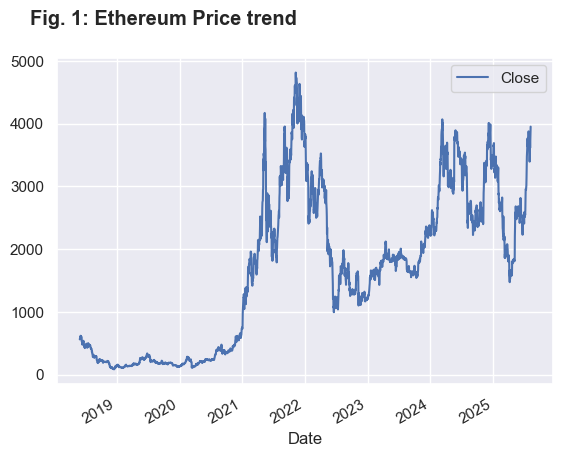

In [85]:
ETH_Data[["Close"]].plot(grid=True)
plt.suptitle(
    "Fig. 1: Ethereum Price trend", fontweight="bold", horizontalalignment="right"
)
plt.show()

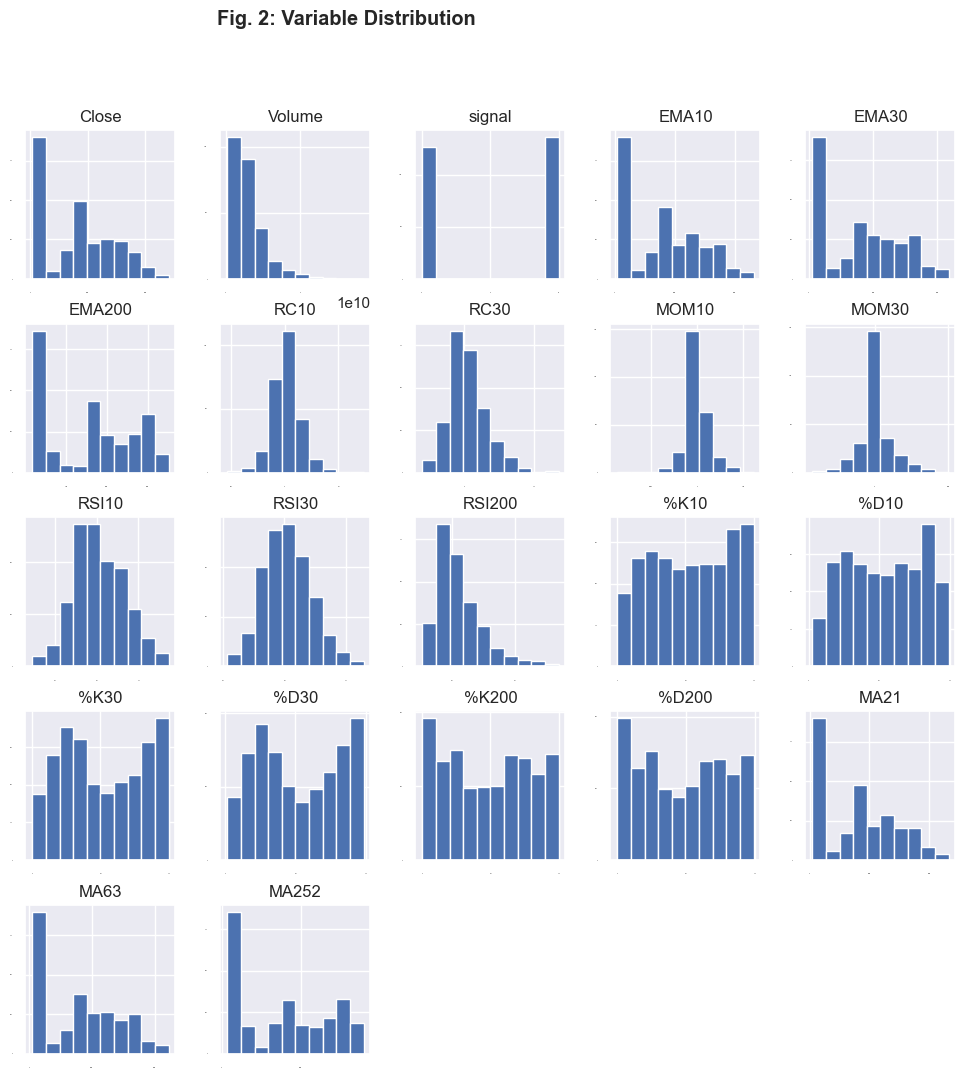

In [86]:
# histograms
ETH_Data.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12, 12))
plt.suptitle(
    "Fig. 2: Variable Distribution", fontweight="bold", horizontalalignment="right"
)
plt.show()

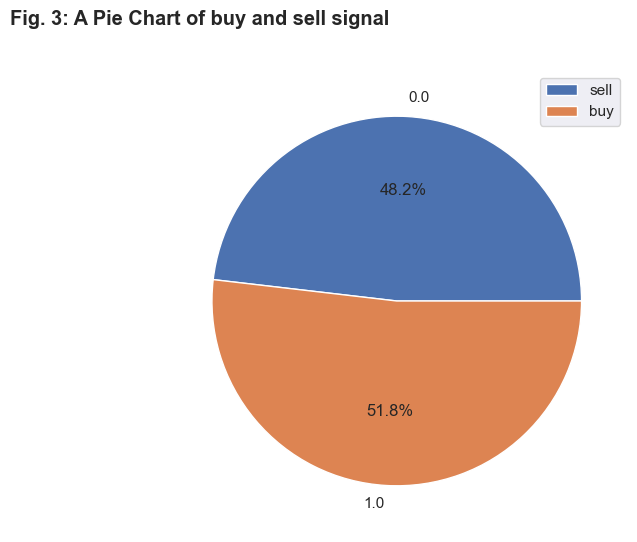

In [87]:
fig = plt.figure()
plot = (
    ETH_Data.groupby("signal")
    .size()
    .plot(kind="pie", figsize=(6, 6), autopct="%1.1f%%", y="Signal")
)
plt.suptitle(
    "Fig. 3: A Pie Chart of buy and sell signal",
    fontweight="bold",
    horizontalalignment="right",
)
plt.legend(["sell", "buy"])
plt.show()

In [88]:
ETH_Data.groupby(["signal"]).size()

signal
0.0    1265
1.0    1362
dtype: int64

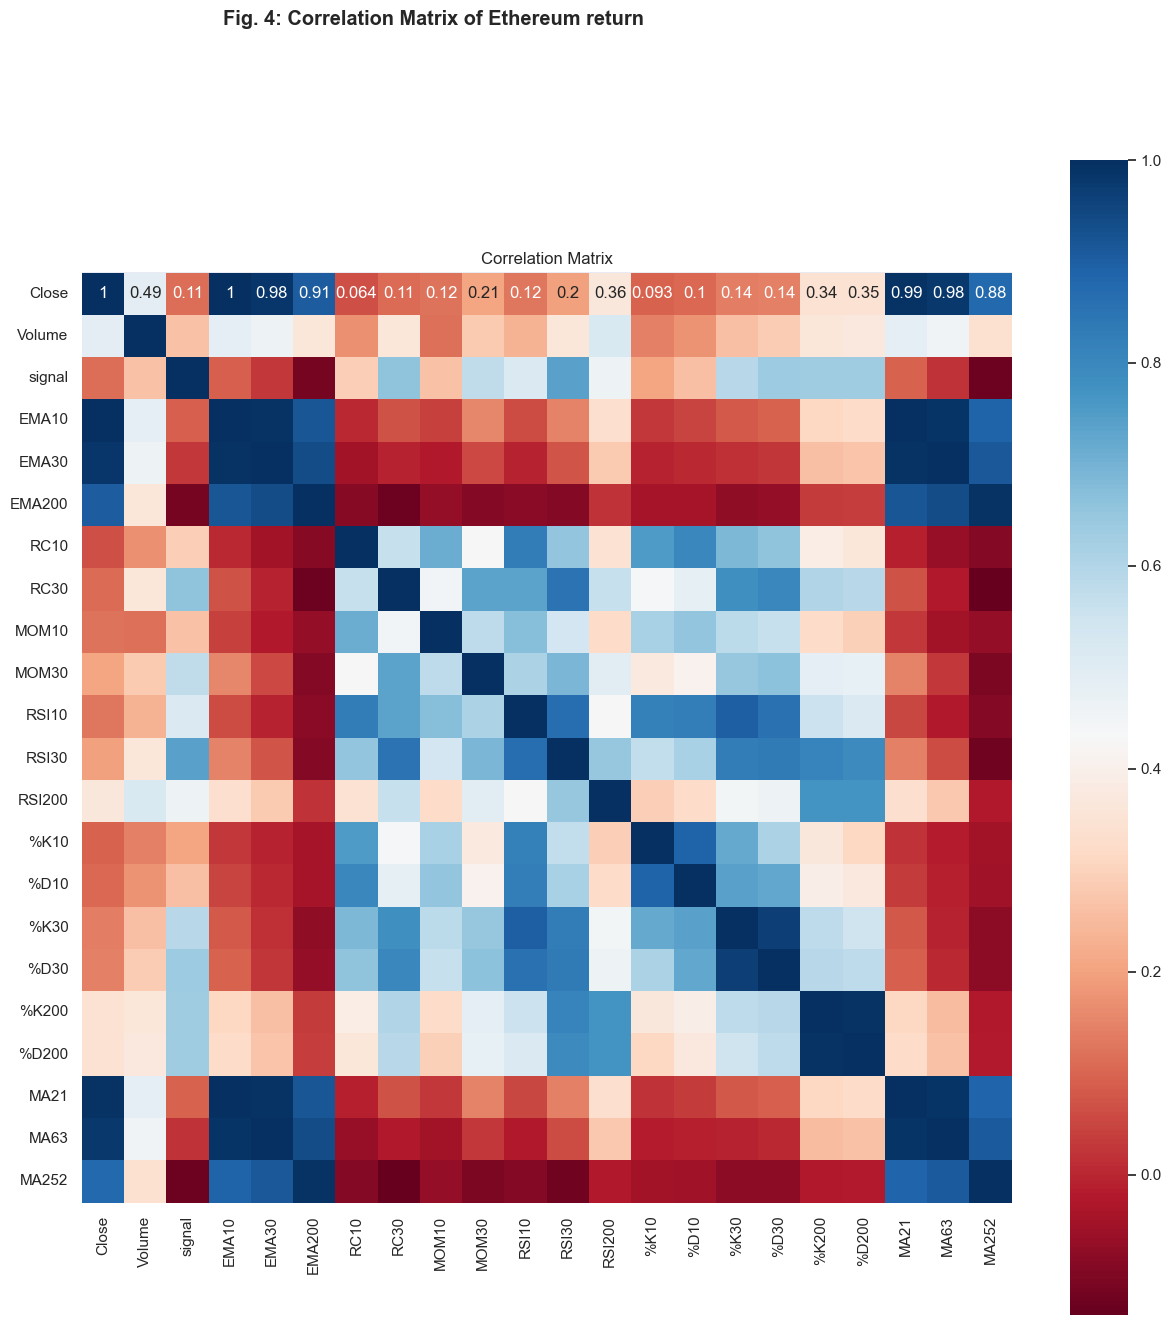

In [89]:
# correlation
ETH_data_returns = ETH_Data.shift(1)
correlation = ETH_data_returns.corr()
plt.figure(figsize=(15, 15))
plt.title("Correlation Matrix")
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap="RdBu")
plt.suptitle(
    "Fig. 4: Correlation Matrix of Ethereum return",
    fontweight="bold",
    horizontalalignment="right",
)
plt.show()

## Spliting the data for training and testing

In [91]:
def get_holdout_set(target, features, period=6):
    idx = pd.IndexSlice
    label = target.name
    dates = np.sort(y.index.get_level_values("Date").unique())
    cv_start, cv_end = dates[0], dates[-period - 2]
    holdout_start, holdout_end = dates[-period - 1], dates[-1]

    df = features.join(target.to_frame())
    train = df.loc[idx[:, cv_start:cv_end], :]
    y_train, X_train = train[label], train.drop(label, axis=1)

    test = df.loc[idx[:, holdout_start:holdout_end], :]
    y_test, X_test = test[label], test.drop(label, axis=1)
    return y_train, X_train, y_test, X_test

In [92]:
subset_validation = ETH_Data[1801:]

In [93]:
subset_validation.shape

(826, 22)

In [94]:
# split out validation dataset for the end
subset_dataset = ETH_Data[:1800]
y = subset_dataset["signal"]
X = subset_dataset.loc[:, ETH_Data.columns != "signal"]
X.index = pd.to_datetime(X.index)
validation_size = 0.2
seed = 1
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=validation_size, random_state=1
)
subset_dataset.shape

(1800, 22)

In [95]:
# subset_validation = ETH_Data[1301:]
y_validation = subset_validation["signal"]
X_validation = subset_validation.loc[:, ETH_Data.columns != "signal"]

In [96]:
# test options for classification
num_folds = 10
seed = 42
scoring = "accuracy"
metrics = {
    "balanced_accuracy": "Accuracy",
    "roc_auc": "AUC",
    "neg_log_loss": "Log Loss",
    "f1_weighted": "F1",
    "precision_weighted": "Precision",
    "recall_weighted": "Recall",
}


In [97]:
def run_cv(clf, X=X, y=y, metrics=metrics, cv=10, fit_params=None, n_jobs=-1):
    start = time()
    scores = cross_validate(
        estimator=clf,
        X=X,
        y=y,
        scoring=list(metrics.keys()),
        cv=cv,
        return_train_score=True,
        n_jobs=n_jobs,
        verbose=1,
        fit_params=fit_params,
    )
    duration = time() - start
    return scores, duration

In [98]:
def stack_results(scores):
    columns = pd.MultiIndex.from_tuples(
        [tuple(m.split("_", 1)) for m in scores.keys()], names=["Dataset", "Metric"]
    )
    data = np.array(list(scores.values())).T
    df = pd.DataFrame(data=data, columns=columns).iloc[:, 2:]
    results = pd.melt(df, value_name="Value")
    results.Metric = results.Metric.apply(lambda x: metrics.get(x))
    results.Dataset = results.Dataset.str.capitalize()
    return results


In [99]:
def plot_result(df, model=None, fname=None):
    m = list(metrics.values())
    g = sns.catplot(
        x="Dataset",
        y="Value",
        hue="Dataset",
        col="Metric",
        data=df,
        col_order=m,
        order=["Train", "Test"],
        kind="box",
        col_wrap=3,
        sharey=False,
        height=4,
        aspect=1.2,
    )
    df = df.groupby(["Metric", "Dataset"]).Value.mean().unstack().loc[m]
    for i, ax in enumerate(g.axes.flat):
        s = f"Train: {df.loc[m[i], 'Train']:>7.4f}\nTest:  {df.loc[m[i], 'Test'] :>7.4f}"
        ax.text(
            0.05,
            0.85,
            s,
            fontsize=10,
            transform=ax.transAxes,
            bbox=dict(facecolor="white", edgecolor="grey", boxstyle="round,pad=0.5"),
        )
    g.fig.suptitle(model, fontsize=16)
    g.fig.subplots_adjust(top=0.9)
    if fname:
        g.savefig(fname, dpi=300);

In [100]:
dummy_clf = DummyClassifier(strategy="stratified", random_state=42)
algo = "dummy_clf"
fname = f"{algo}.joblib"

dummy_cv_result, run_time_algo = run_cv(dummy_clf)
joblib.dump(dummy_cv_result, fname)
dummy_result = stack_results(dummy_cv_result)
dummy_result.groupby(["Metric", "Dataset"]).Value.mean().unstack()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 22 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.5s finished


Dataset,Test,Train
Metric,,
AUC,0.494726,0.498259
Accuracy,0.494726,0.498259
F1,0.496187,0.499519
Log Loss,-18.061875,-18.044076
Precision,0.496086,0.499687
Recall,0.498889,0.499383


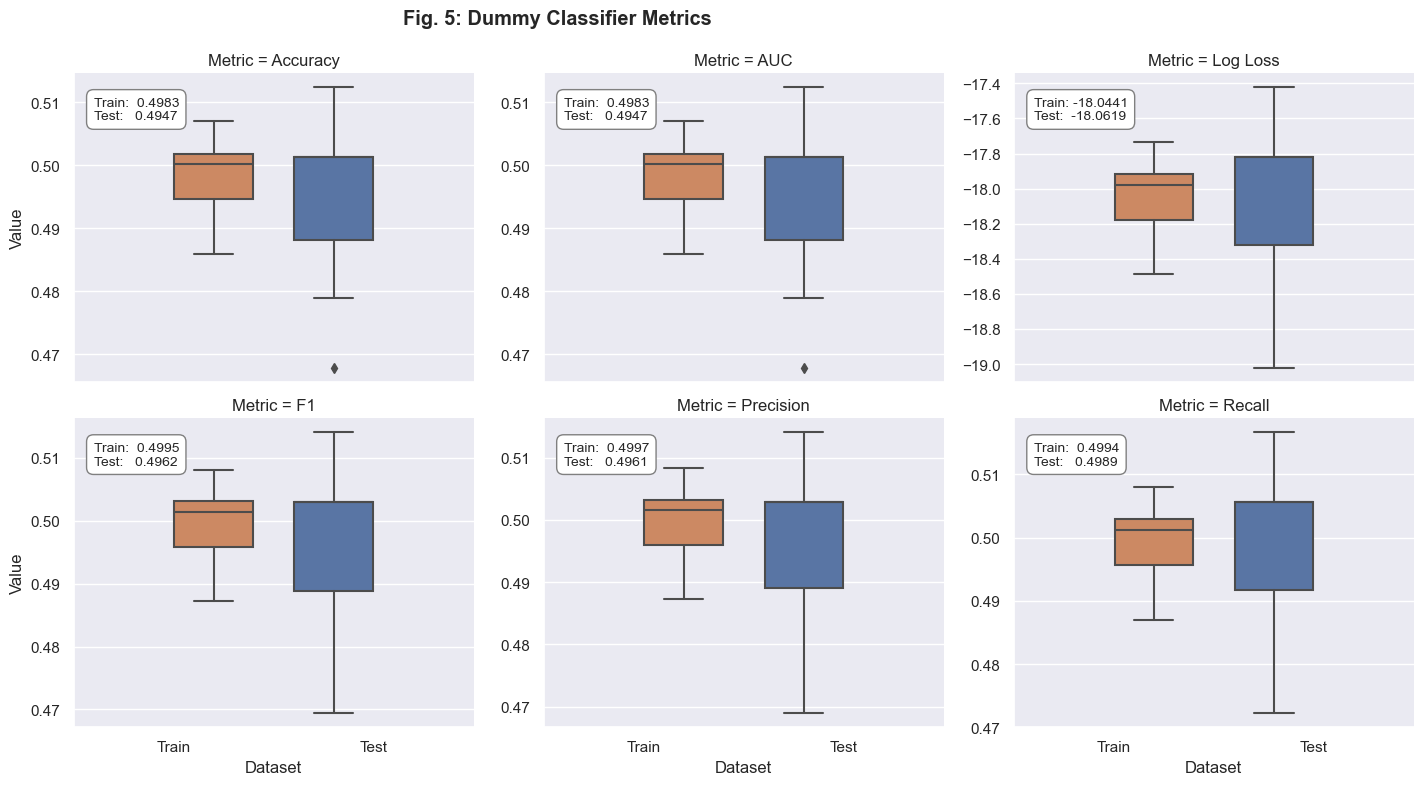

In [101]:
plot_result(dummy_result, model="Dummy Classifier")
plt.suptitle(
    "Fig. 5: Dummy Classifier Metrics", fontweight="bold", horizontalalignment="right"
)

plt.show()

## Comparing Algorithms 

In [103]:
# spot check the algorithms
models = []
models.append(("LR", LogisticRegression(n_jobs=-1)))
models.append(("LDA", LinearDiscriminantAnalysis()))
models.append(("KNN", KNeighborsClassifier()))
models.append(("CART", DecisionTreeClassifier()))
models.append(("NB", GaussianNB()))
# Neural Network
models.append(("NN", MLPClassifier()))
# Ensemble Models
# Boosting methods
models.append(("AB", AdaBoostClassifier()))
models.append(("GBM", GradientBoostingClassifier()))
# Bagging methods
models.append(("RF", RandomForestClassifier(n_jobs=-1)))

In [104]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.518750 (0.038295)
LDA: 0.943750 (0.016854)
KNN: 0.597222 (0.050747)
CART: 0.919444 (0.015590)
NB: 0.600694 (0.028842)
NN: 0.521528 (0.036806)
AB: 0.952778 (0.015775)
GBM: 0.960417 (0.012442)
RF: 0.962500 (0.009919)


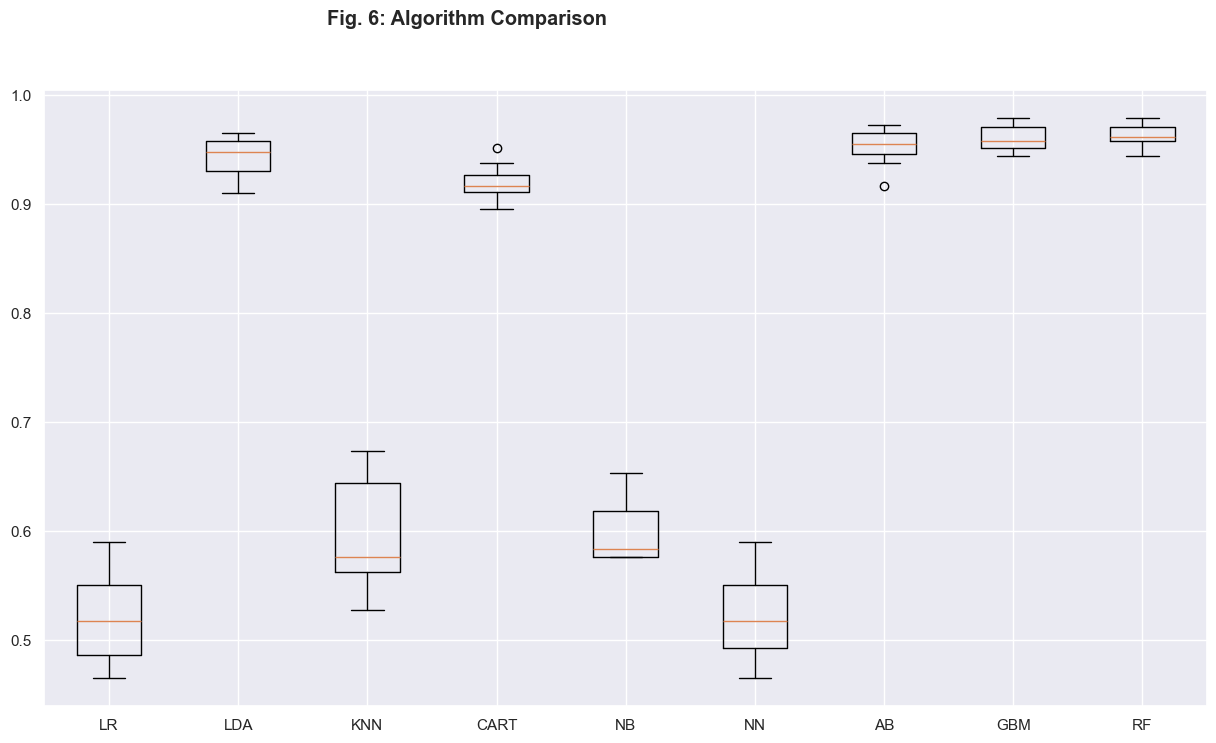

In [105]:
# compare algorithms
fig = plt.figure()
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15, 8)
plt.suptitle(
    "Fig. 6: Algorithm Comparison", fontweight="bold", horizontalalignment="right"
)
plt.show()

## Grid Search

In [123]:
# Grid Search: Random Forest Classifier

scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
n_estimators = [20, 80]
max_depth = [5, 10]
criterion = ["gini", "entropy"]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, criterion=criterion)
model = RandomForestClassifier(n_jobs=-1)
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, y_train)

# Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_["mean_test_score"]
stds = grid_result.cv_results_["std_test_score"]
params = grid_result.cv_results_["params"]
ranks = grid_result.cv_results_["rank_test_score"]
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.964583 using {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 80}
#8 0.936806 (0.016271) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 20}
#6 0.943056 (0.012345) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 80}
#3 0.958333 (0.013889) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 20}
#4 0.957639 (0.010509) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 80}
#7 0.940972 (0.017637) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 20}
#5 0.947222 (0.015278) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 80}
#2 0.959028 (0.012596) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 20}
#1 0.964583 (0.010039) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 80}


In [151]:
# prepare model
model = RandomForestClassifier(
    criterion="entropy", n_estimators=80, max_depth=10, n_jobs=-1
)  # `rbf` is default kernel

In [152]:
algo_forest = "random_forest"
fname = f"{algo_forest}.joblib"

random_forest_cv_result, run_time_algo_forest = run_cv(model)
joblib.dump(random_forest_cv_result, fname)
rf_result = stack_results(random_forest_cv_result)
rf_result.groupby(["Metric", "Dataset"]).Value.mean().unstack()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 22 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.3s finished


Dataset,Test,Train
Metric,,
AUC,0.959070,1.000000
Accuracy,0.801485,0.999766
F1,0.785497,0.999753
Log Loss,-0.444524,-0.034780
Precision,0.858181,0.999753
Recall,0.801667,0.999753


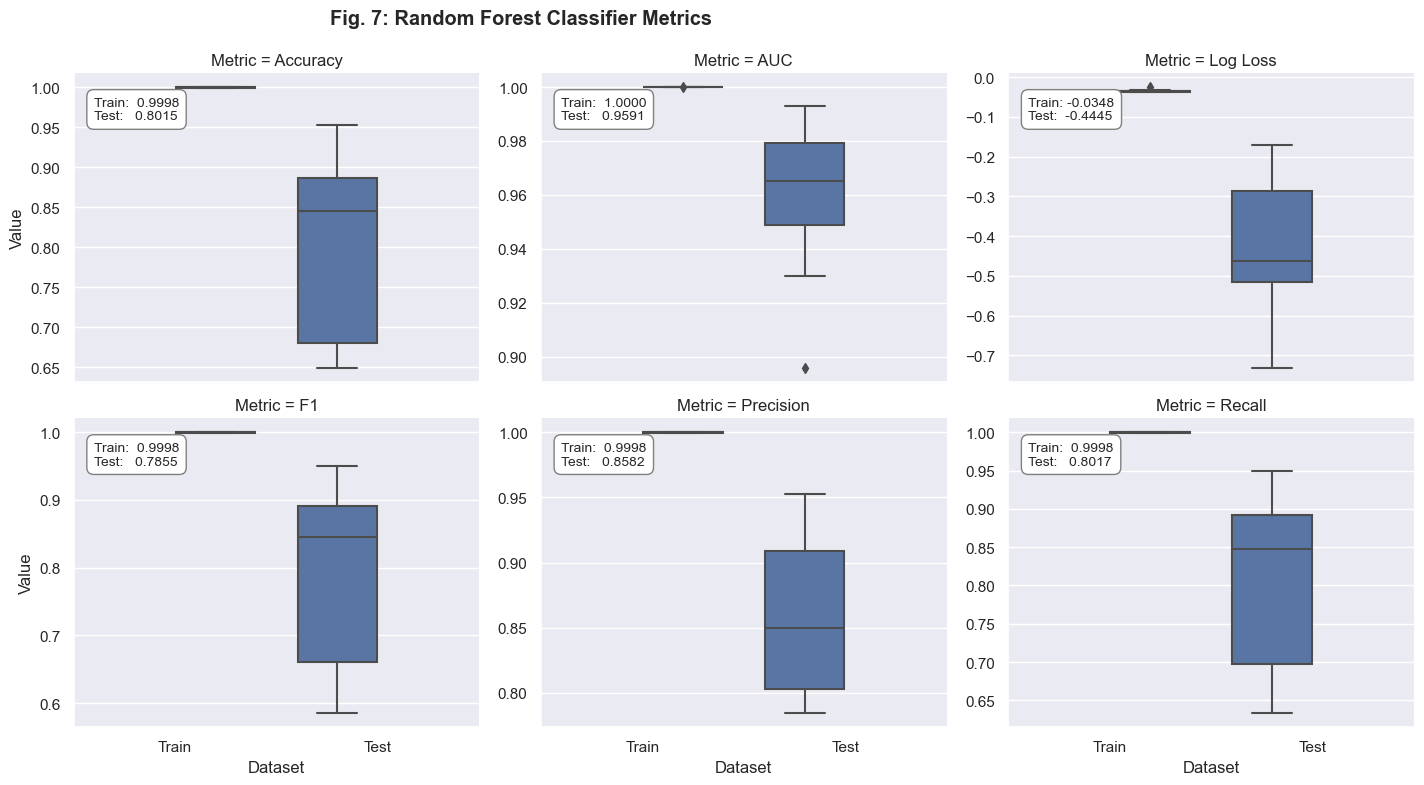

In [153]:
plot_result(rf_result, model="Random Forest Classifier")
plt.suptitle(
    "Fig. 7: Random Forest Classifier Metrics",
    fontweight="bold",
    horizontalalignment="right",
)
plt.show()

In [154]:
results = {
    "Baseline": dummy_result,
    "Random Forest": rf_result,
}
df = pd.DataFrame()
for model, result in results.items():
    df = pd.concat(
        [
            df,
            result.groupby(["Metric", "Dataset"])
            .Value.mean()
            .unstack()["Test"]
            .to_frame(model),
        ],
        axis=1,
    )

df.T.sort_values("AUC", ascending=False)

Metric,AUC,Accuracy,F1,Log Loss,Precision,Recall
Random Forest,0.959070,0.801485,0.785497,-0.444524,0.858181,0.801667
Baseline,0.494726,0.494726,0.496187,-18.061875,0.496086,0.498889


In [155]:
model = RandomForestClassifier(
    criterion="entropy", n_estimators=80, max_depth=10, n_jobs=-1
)
model.fit(X_train, y_train)
# estimate accuracy on validation set
predictions = model.predict(X_test)
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

0.9527777777777777
[[153   6]
 [ 11 190]]
              precision    recall  f1-score   support

         0.0       0.93      0.96      0.95       159
         1.0       0.97      0.95      0.96       201

    accuracy                           0.95       360
   macro avg       0.95      0.95      0.95       360
weighted avg       0.95      0.95      0.95       360



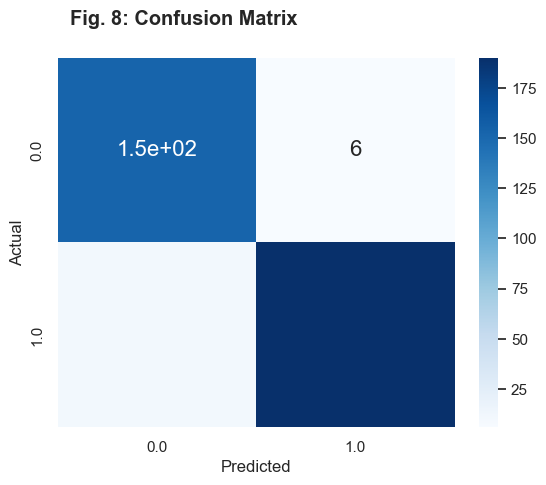

In [156]:
df_cm = pd.DataFrame(
    confusion_matrix(y_test, predictions),
    columns=np.unique(y_test),
    index=np.unique(y_test),
)
df_cm.index.name = "Actual"
df_cm.columns.name = "Predicted"
sns.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16})  # font sizes
plt.suptitle("Fig. 8: Confusion Matrix", fontweight="bold", horizontalalignment="right")
plt.show()

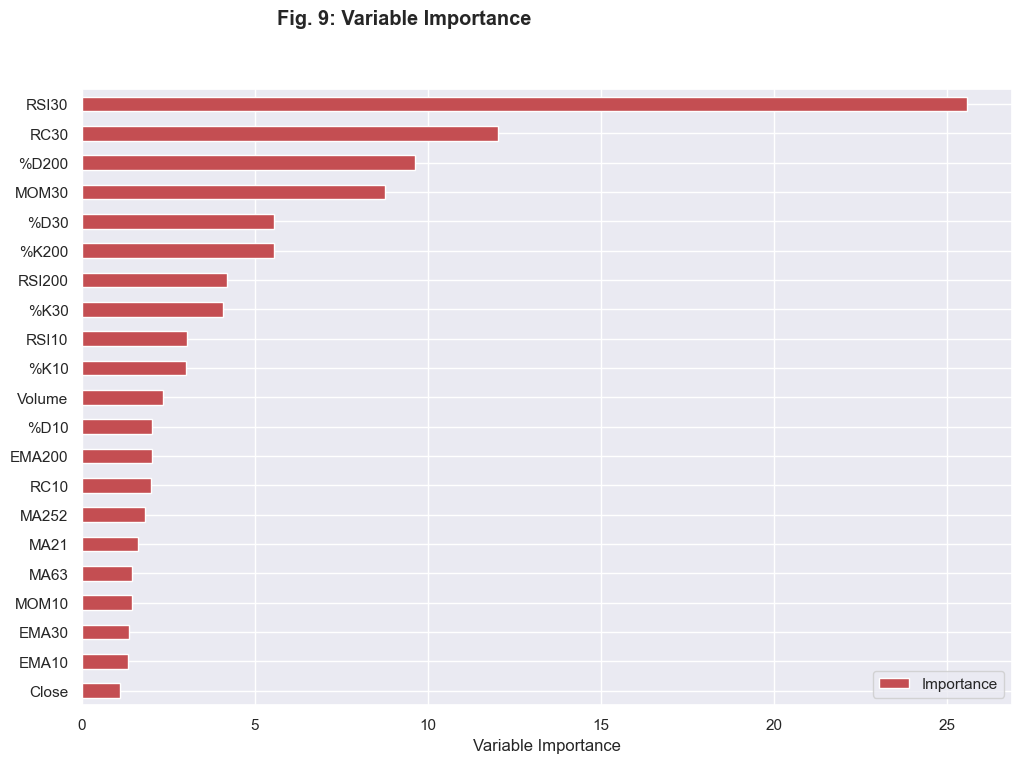

In [157]:
Importance = pd.DataFrame(
    {"Importance": model.feature_importances_ * 100}, index=X.columns
)
Importance.sort_values("Importance", axis=0, ascending=True).plot(
    kind="barh", color="r", figsize=(12, 8)
)
plt.xlabel("Variable Importance")
plt.suptitle(
    "Fig. 9: Variable Importance", fontweight="bold", horizontalalignment="right"
)
plt.show()

In [158]:
def stratified_kfold_score(clf, X_train, y_train, n_fold):
    X, y = X_train.values, y_train.values
    strat_kfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=1)
    accuracy_list = []

    for train_index, test_index in strat_kfold.split(X, y):
        x_train_fold, x_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]
        clf.fit(x_train_fold, y_train_fold)
        preds = clf.predict(x_test_fold)
        accuracy_test = accuracy_score(preds, y_test_fold)
        accuracy_list.append(accuracy_test)

    return np.array(accuracy_list).mean()

In [159]:
def bo_params_rf(max_samples, n_estimators, max_features):
    params = {
        "max_samples": max_samples,
        "max_features": max_features,
        "n_estimators": int(n_estimators),
    }
    clf = RandomForestClassifier(
        max_samples=params["max_samples"],
        max_features=params["max_features"],
        n_estimators=params["n_estimators"],
    )
    score = stratified_kfold_score(clf, X_train, y_train, 5)
    return score

In [160]:
rf_bo = BayesianOptimization(
    bo_params_rf,
    {"max_samples": (0.2, 1), "max_features": (0.5, 1), "n_estimators": (50, 200)},
)

In [161]:
results = rf_bo.maximize(n_iter=200, init_points=20,)# acq="ei")

|   iter    |  target   | max_sa... | max_fe... | n_esti... |
-------------------------------------------------------------
| 1         | 0.9534722 | 0.9079599 | 0.5836686 | 119.99699 |
| 2         | 0.9430555 | 0.3897893 | 0.6579367 | 126.13246 |
| 3         | 0.9451388 | 0.3190956 | 0.7958945 | 53.718210 |
| 4         | 0.95      | 0.7709508 | 0.8864397 | 144.17191 |
| 5         | 0.9465277 | 0.9413404 | 0.9459722 | 173.84381 |
| 6         | 0.9409722 | 0.2902881 | 0.5545949 | 174.02809 |
| 7         | 0.9520833 | 0.7770421 | 0.5194400 | 137.17506 |
| 8         | 0.9493055 | 0.5536183 | 0.9719105 | 185.93484 |
| 9         | 0.9493055 | 0.8045831 | 0.6395402 | 190.29862 |
| 10        | 0.95      | 0.6677405 | 0.9015650 | 176.51587 |
| 11        | 0.9458333 | 0.4965525 | 0.9766607 | 75.620826 |
| 12        | 0.9534722 | 0.9519884 | 0.5766256 | 118.77574 |
| 13        | 0.9451388 | 0.5039697 | 0.9687641 | 159.98437 |
| 14        | 0.9513888 | 0.8560965 | 0.7461894 | 170.24537 |
| 15    

In [162]:
params = rf_bo.max["params"]
params["n_estimators"] = int(params["n_estimators"])
print(params)

{'max_samples': 1.0, 'max_features': 0.5, 'n_estimators': 119}


In [163]:
rf_v1 = RandomForestClassifier(
    max_samples=params["max_samples"],
    max_features=params["max_features"],
    n_estimators=params["n_estimators"],
)

In [164]:
rf_v1.fit(X_train, y_train)

RandomForestClassifier(max_features=0.5, max_samples=1.0, n_estimators=119)

In [165]:

preds = rf_v1.predict(X_test)
print(classification_report(preds, y_test))

              precision    recall  f1-score   support

         0.0       0.96      0.93      0.94       164
         1.0       0.94      0.96      0.95       196

    accuracy                           0.95       360
   macro avg       0.95      0.95      0.95       360
weighted avg       0.95      0.95      0.95       360



In [166]:
print("Precision:{}".format(precision_score(preds, y_test)))
print("Recall:{}".format(recall_score(preds, y_test)))
print("F1 Score:{}".format((f1_score(preds, y_test))))

Precision:0.9402985074626866
Recall:0.9642857142857143
F1 Score:0.9521410579345089


In [167]:
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
scores = []

for (train, test), i in zip(cv.split(X_train, y_train), range(5)):
    rf_v1.fit(X.iloc[train], y.iloc[train])
    preds = rf_v1.predict(X_train.iloc[test])
    accuracy = accuracy_score(preds, y_train.iloc[test])
    scores.append(accuracy)

df_val = pd.DataFrame(scores, columns=["Accuracy Test"])
print(
    "KFold validation mean accuracy on test set : {}".format(
        df_val["Accuracy Test"].mean()
    )
)

KFold validation mean accuracy on test set : 0.9791666666666667


## Backtest

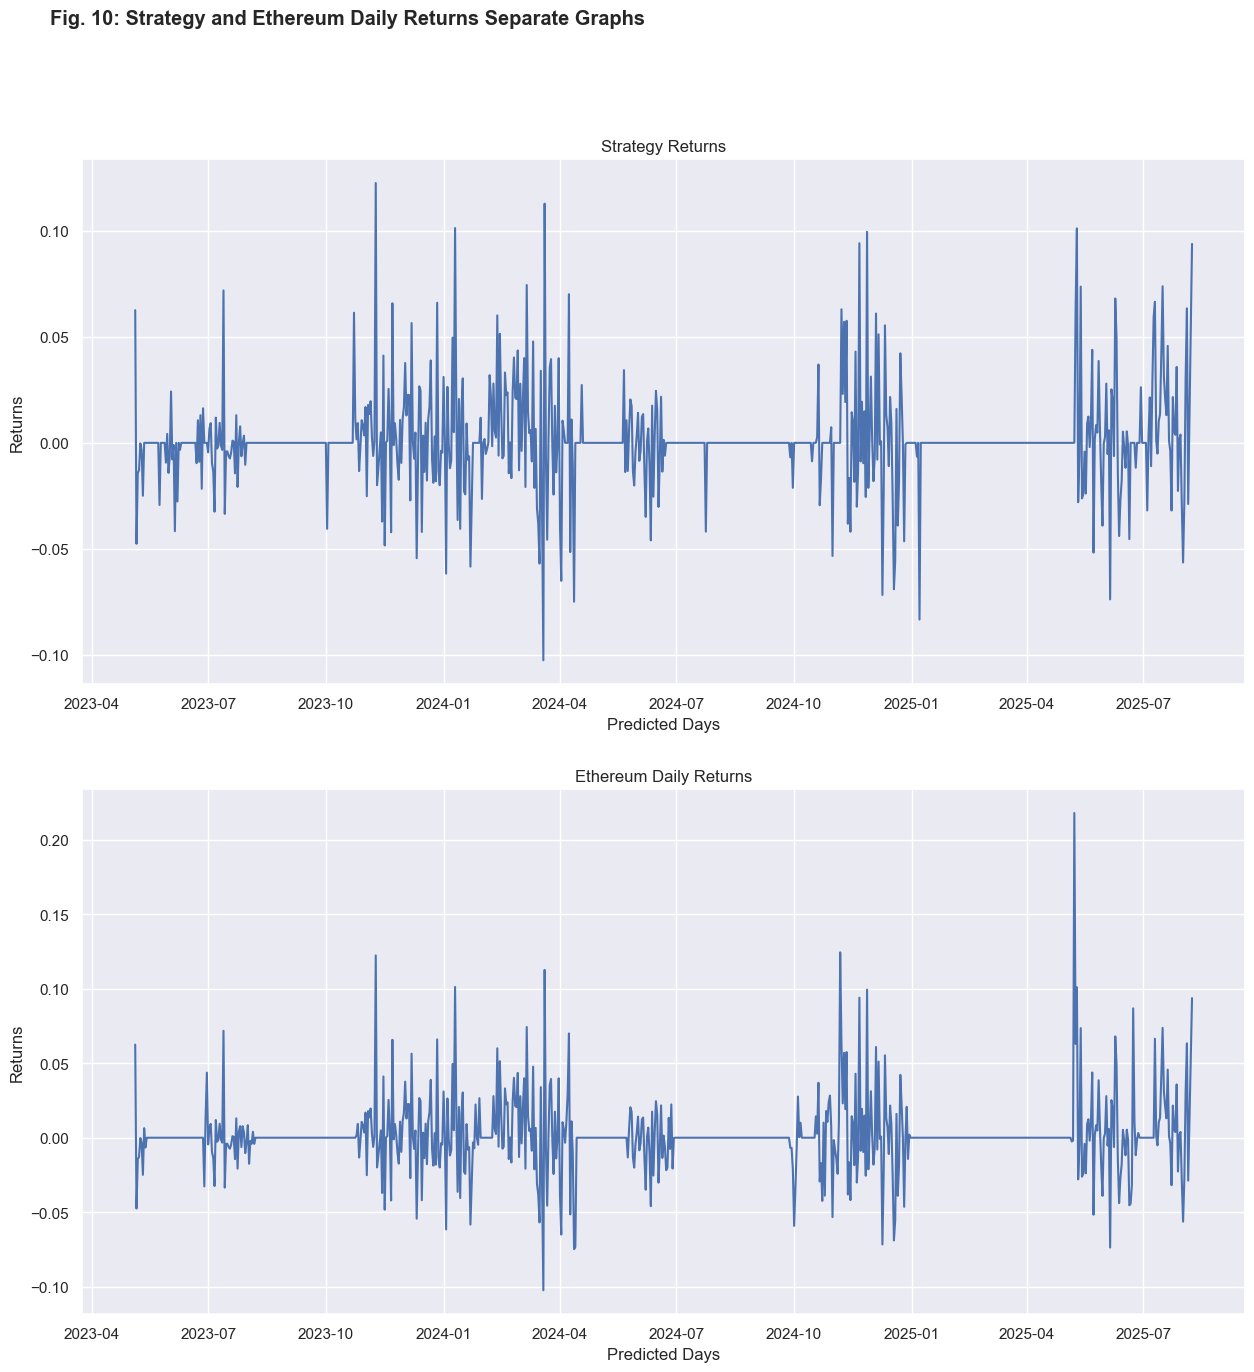

In [214]:
# Create column for Strategy Returns by multiplying the daily returns by the position that was held at close
# of business the previous day
backtestdata = pd.DataFrame(index=X_validation.index)
validation_prediction = rf_v1.predict(X_validation)
backtestdata["signal_pred"] = validation_prediction
backtestdata["signal_actual"] = y_validation
backtestdata["Market Returns"] = X_validation["Close"].pct_change()
backtestdata["Actual Returns"] = backtestdata["Market Returns"] * backtestdata[
    "signal_actual"
].shift(1)
backtestdata["Strategy Returns"] = backtestdata["Market Returns"] * backtestdata[
    "signal_pred"
].shift(1)
# backtestdata=backtestdata.reset_index()
backtestdata.head()

fig, axs = plt.subplots(2, figsize=(15, 15))
fig.suptitle("Vertically stacked subplots")
axs[0].plot(backtestdata["Strategy Returns"])
axs[0].set_title("Strategy Returns")
axs[1].plot(backtestdata["Actual Returns"])
axs[1].set_title("Ethereum Daily Returns")

for ax in axs.flat:
    ax.set(xlabel="Predicted Days", ylabel="Returns")

# `backtestdata`[['Strategy Returns','Actual Returns']].plot()
# `plt.title`('Cumulative Strategy Returns vs Cumulative Actual Returns')
plt.suptitle(
    "Fig. 10: Strategy and Ethereum Daily Returns Separate Graphs",
    fontweight="bold",
    horizontalalignment="right",
)
plt.show()

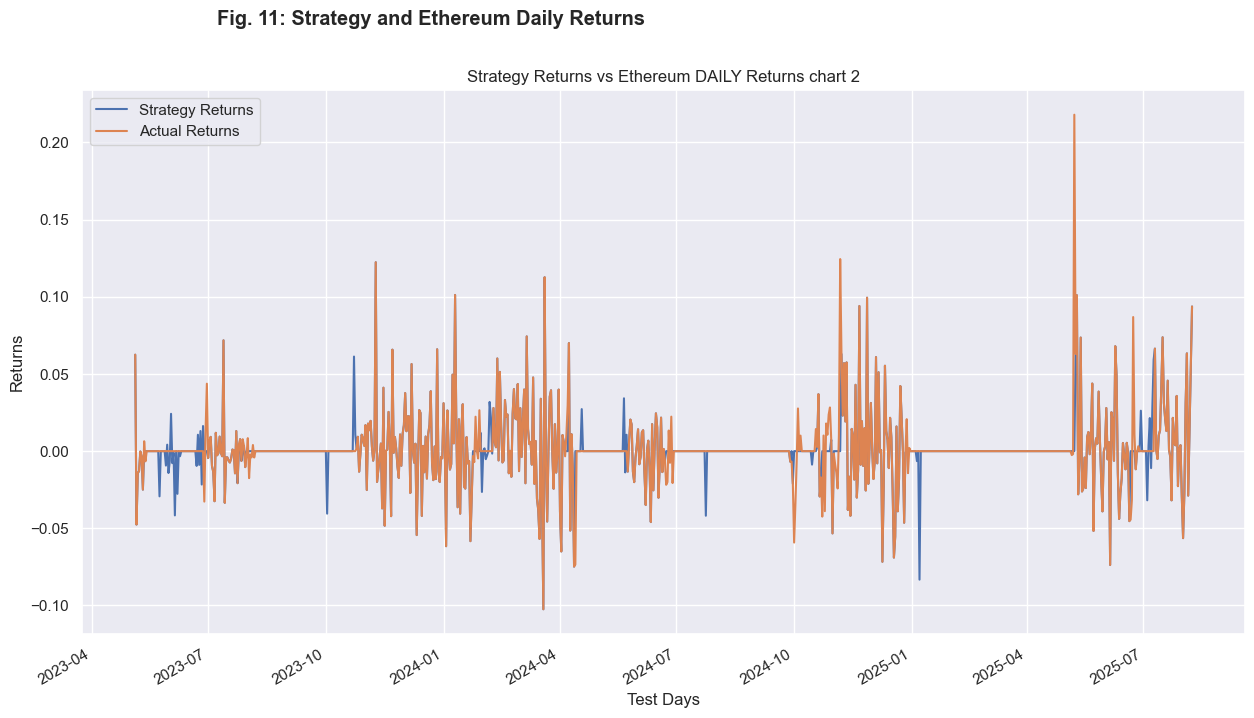

In [212]:
backtestdata[["Strategy Returns", "Actual Returns"]].plot(figsize=(15, 8))
plt.title("Strategy Returns vs Ethereum DAILY Returns chart 2")
plt.suptitle(
    "Fig. 11: Strategy and Ethereum Daily Returns",
    fontweight="bold",
    horizontalalignment="right",
)
plt.xlabel("Test Days")
plt.ylabel("Returns")
plt.show()

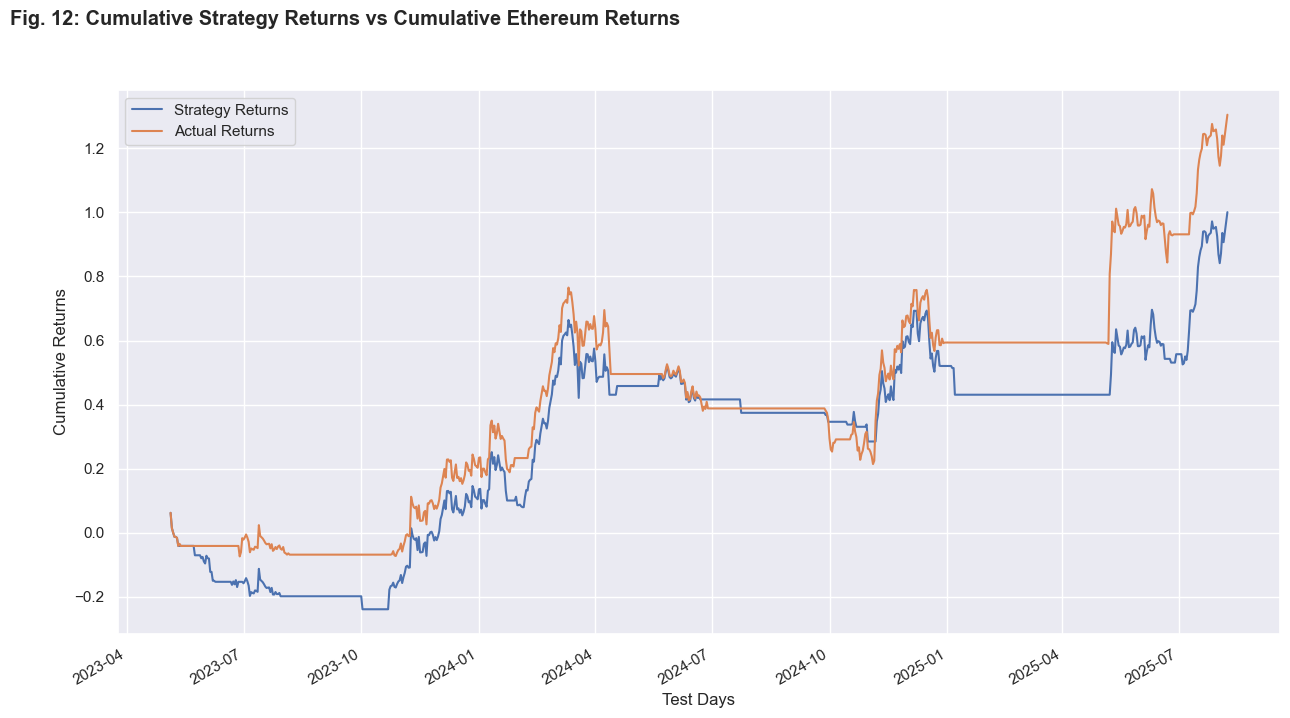

In [208]:
backtestdata[["Strategy Returns", "Actual Returns"]].cumsum().plot(figsize=(15, 8))
plt.xlabel("Test Days")
plt.ylabel("Cumulative Returns")
plt.suptitle(
    "Fig. 12: Cumulative Strategy Returns vs Cumulative Ethereum Returns",
    fontweight="bold",
    horizontalalignment="right",
)
plt.show()